# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

# Solution

## EDA & Preprocessing

The provided data contains 20 files, each less than 0.5MB, so we can load all the data into the memory. Each file contains data about one machine from 4 sensors spanning from 2019-01-01 00:00:00.000000000 to 2021-09-26 15:59:50.396798944. Note that each file contains 3000 rows and no missing values.

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')
%matplotlib inline

# constants
N = 20 # number of machines
COLOR_DICT = {0: '#5897C5', 1: '#E95D44', 2: '#DCB357', 3: '#79945F'}

machine_0 = pd.read_csv(f"exampleco_data/machine_0.csv",index_col=0)
row_count = len(machine_0)
first_date = machine_0.index[0]
last_date = machine_0.index[-1]
for i in range(1, 20):
    machine = pd.read_csv(f"exampleco_data/machine_{i}.csv",index_col=0)
    assert len(machine) == row_count
    assert not machine.isnull().values.any()
    assert machine.index[0] == first_date
    assert machine.index[-1] == last_date

machine_0.head()

0         1          2          3
2019-01-01 00:00:00.000000000  12.626096  8.803120 -11.809200  10.083961
2019-01-01 08:00:09.603201067  10.831994  2.816327  11.554778  21.892853
2019-01-01 16:00:19.206402134  21.083510 -0.672645 -17.839178  -1.349024
2019-01-02 00:00:28.809603201  32.294495  6.525132 -13.498586  -4.250752
2019-01-02 08:00:38.412804268  28.057100  3.691359  21.984744  13.670561

We can use the following code to visualize the data from all 4 sensors for a given machine.

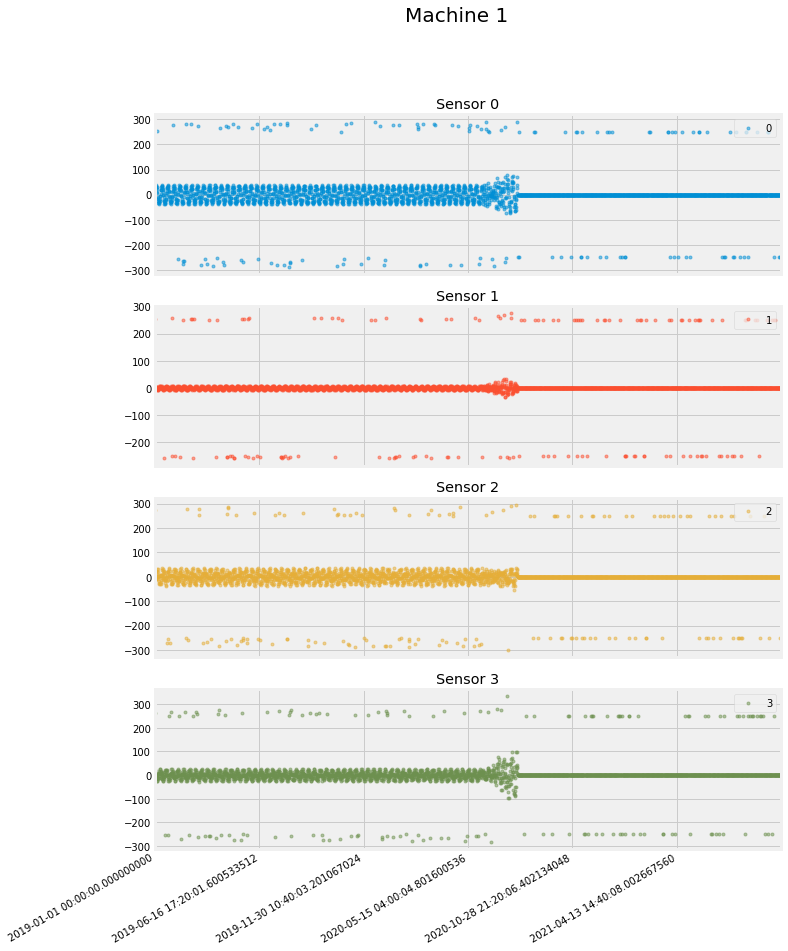

In [2]:

def visualize_machine(id, denoised=False):
    if denoised:
        data = pd.read_csv(f"denoised_data/machine_{id}.csv",index_col=0)
    else:
        data = pd.read_csv(f"exampleco_data/machine_{id}.csv",index_col=0)

    cols_plot = ['0', '1', '2', '3']
    axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(10, 15), subplots=True)
    for ax in axes:
        label = ax.get_legend_handles_labels()[1][0]
        ax.set_title(f"Sensor {label}")
        ax.legend(loc='upper right')
    plt.suptitle(f"Machine {id}", fontsize=20)

visualize_machine(1)

We can clearly distinguish three modes of operation. For example, for sensor 3 these can be manually labeled as follows:

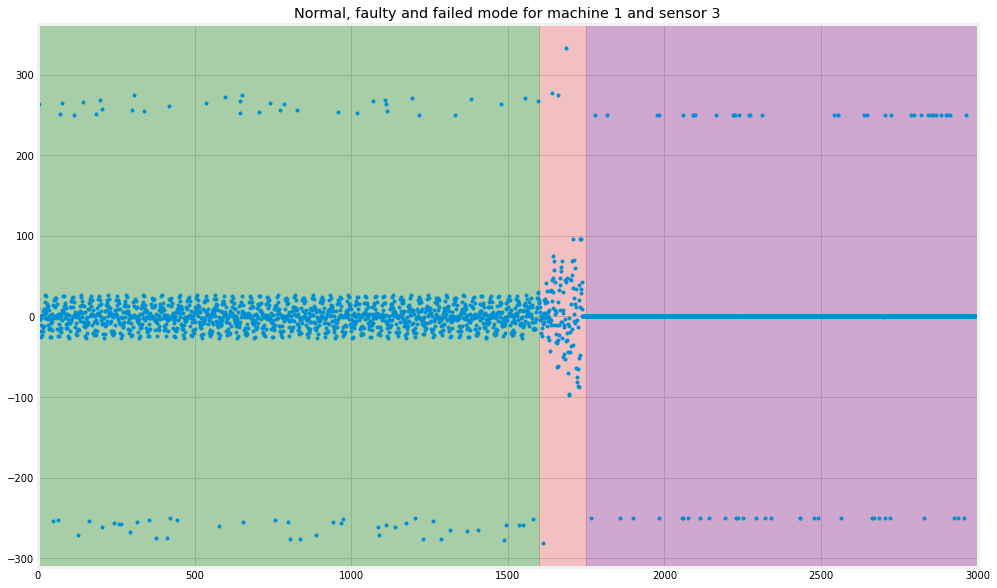

In [3]:
def visualize_sensor_for_one_machine(machine, sensor, normal_to_faulty=None, faulty_to_failed=None, denoised=False):
    if denoised:
        data = pd.read_csv(f"denoised_data/machine_{machine}.csv",index_col=0)
    else:
        data = pd.read_csv(f"exampleco_data/machine_{machine}.csv",index_col=0)
    plt.figure(figsize=(15,10))
    plt.plot(range(len(data)), data[str(sensor)], marker='.', linestyle='None')
    
    if normal_to_faulty is not None and faulty_to_failed is not None:
        ax = plt.gca()
        ax.axvspan(0, normal_to_faulty, color = 'green', alpha=0.3)
        ax.axvspan(normal_to_faulty, faulty_to_failed, color = 'red', alpha=0.2)
        ax.axvspan(faulty_to_failed, 3000, color = 'purple', alpha=0.3)
        ax.set_xlim(0, 3000)
        ax.set_title(f"Normal, faulty and failed mode for machine {machine} and sensor {sensor}")

visualize_sensor_for_one_machine(1, 3, 1600, 1750)

Before we procede to predicting failure, we need to address the noise due to comunication errors. So far, it seems that sensors' values with absolute value above 200 can be attributed to communiation errors. Let's further investigate this hypothesis. The following code visualizes all 4 sensor for a few machines.

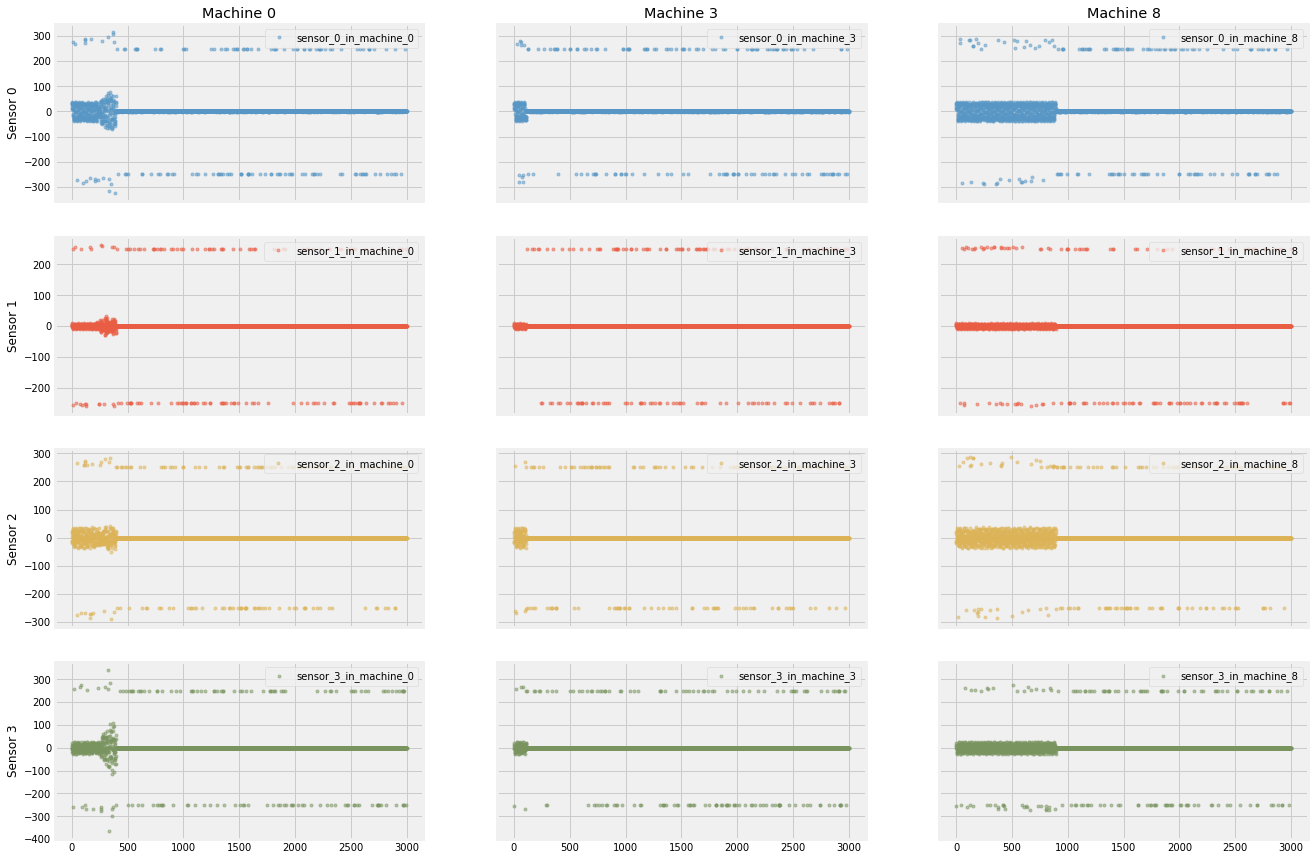

In [4]:
def visualize_all_sensors_for_machines(machine_ids=[7, 9, 11], denoised=False):
    fig, ax = plt.subplots(4, len(machine_ids), sharex='col', sharey='row', figsize=(20, 15))
    sensors = [0, 1, 2, 3]

    first_machine = machine_ids[0]
    col_count = 0
    for i in range(len(machine_ids)):
        if denoised:
            data = pd.read_csv(f"denoised_data/machine_{machine_ids[i]}.csv",index_col=0)
        else:
            data = pd.read_csv(f"exampleco_data/machine_{machine_ids[i]}.csv",index_col=0)
            
        ax[0, i].set_title(f"Machine {machine_ids[i]}")
        for sensor in range(4):
            ax[sensor, i].plot(
                range(len(data)),
                data[str(sensor)],
                marker='.',
                alpha=0.5,
                linestyle='None',
                label=f"sensor_{sensor}_in_machine_{machine_ids[i]}",
                color=COLOR_DICT[sensor],
            )
            ax[sensor, i].legend(loc='upper right')

    for sensor in range(4):
        ax[sensor, 0].set_ylabel(f"Sensor {sensor}")

visualize_all_sensors_for_machines([0, 3, 8])



The few examples cosidered above corroborate the hypothesis that values with absolute value above 200 can be attributed to the communication error. This is because that these values are far away from neighboring values, and we would expect the data from sensors more "continuous". However, we don't want to make this important decision (deleting all these allegedly falsey values) based on looking at few examples.

In general, we would expect the error values to make a small fraction of the entire data. Let's see if it is the case if we assume that values with absolute value greater than 200 are error values.  

In [5]:
for i in range(N):
    machine = pd.read_csv(f"exampleco_data/machine_{i}.csv",index_col=0)
    for sensor in range(3):
        percentage_of_error_values = len(machine[abs(machine[str(sensor)]) > 200])/len(machine)
        if percentage_of_error_values > 0.05:
            print("More than 0.05 of error values")

Since there is no machine and sensor for which there are more than 5% of error values according to our rule, we will accept use this approach.  We will replace these error values with the mean of previous and next values.

For convenience, we save the de-noised data.

In [6]:
import os

def replace_with_mean_of_prev_and_next(df):
    for column in df.columns:
        df[column] = df[column].interpolate()
    
    if df.isnull().values.any():
        # special case, the first value is missing
        df = df.fillna(method='backfill')

    return df


for i in range(N):
    df = pd.read_csv(f"exampleco_data/machine_{i}.csv",index_col=0)
    df[abs(df) > 200] = None
    
    denoised_df = replace_with_mean_of_prev_and_next(df)
    
    # save the cleanned data
    save_dir = os.path.join(os.getcwd(), 'denoised_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    # check that all NaN values were replaced
    assert not denoised_df.isnull().values.any()

    denoised_df.to_csv(os.path.join(save_dir, f"machine_{i}.csv"))
    


Let's visualize the denoised data.

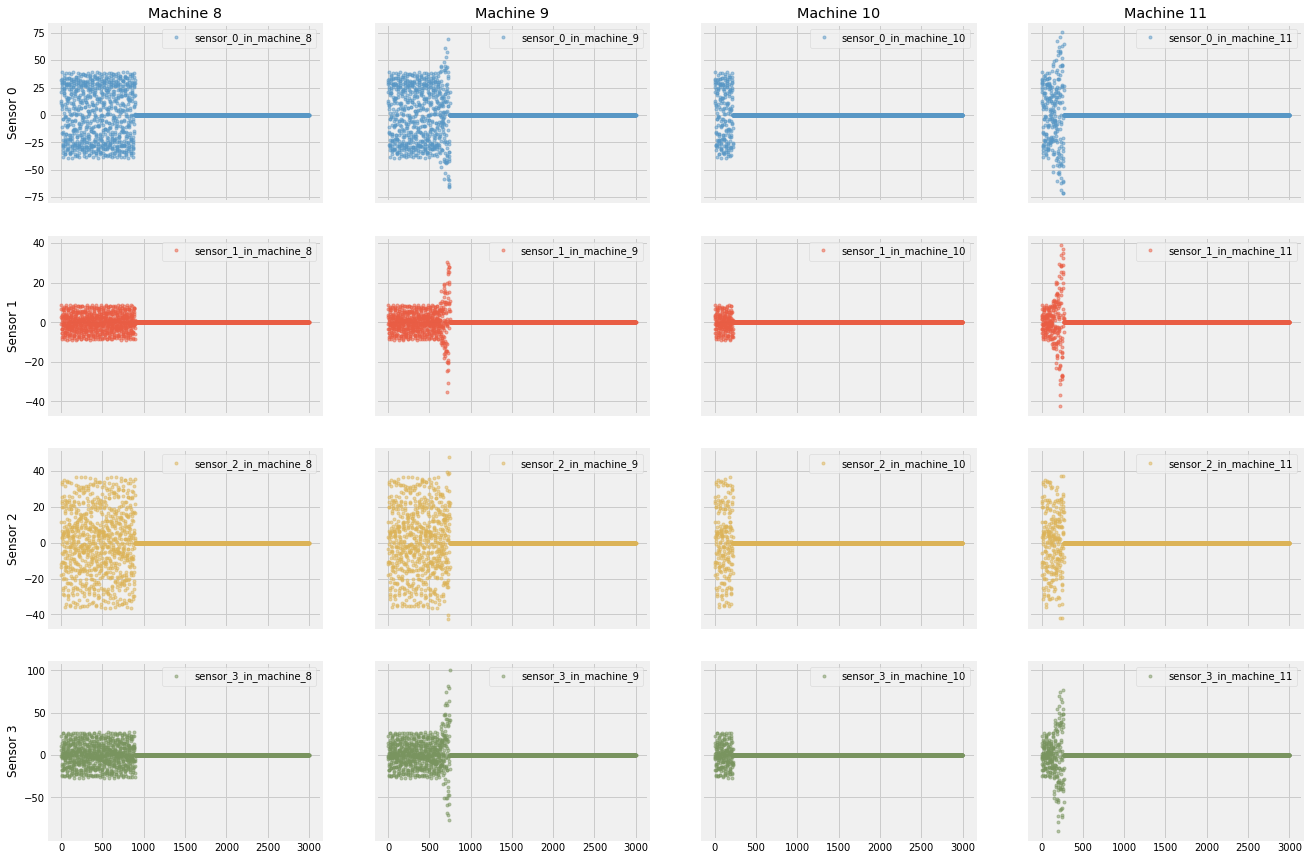

In [7]:
visualize_all_sensors_for_machines(range(8, 12), denoised=True)

We can see that usually the faulty mode can be characterized by values falling outside of a "normal" range. However, this is not the case for machine 3, 8 and 10.

We will use Plotly to further investigate normal and faulty mode. If the plot below is not displayed try:
* runnning `conda install plotly`
* if this doesn't help, run `conda install --yes --prefix {sys.prefix} plotly`
* if this doesn't help, run `jupyter labextension install @jupyterlab/plotly-extension` and then restart the notebook

Let's consider an example of machine 2.

In [8]:
import sys
import plotly.graph_objects as go

def visualize_machine_and_one_sensor_with_plotly(machine, sensor, mode='markers'):
    df = pd.read_csv(f"denoised_data/machine_{machine}.csv",index_col=0)

    fig = go.Figure()
    print(range(len(df.index)))
    fig.add_trace(go.Scatter(x=list(range(len(df))), y=df[str(sensor)], name="AAPL High",
                             line_color=COLOR_DICT[sensor], mode=mode))


    fig.update_layout(title_text=f"Sensor {sensor} in machine {machine}",
                      xaxis_rangeslider_visible=True, plot_bgcolor='#F0F0F0')
    fig.show()


range(0, 3000)


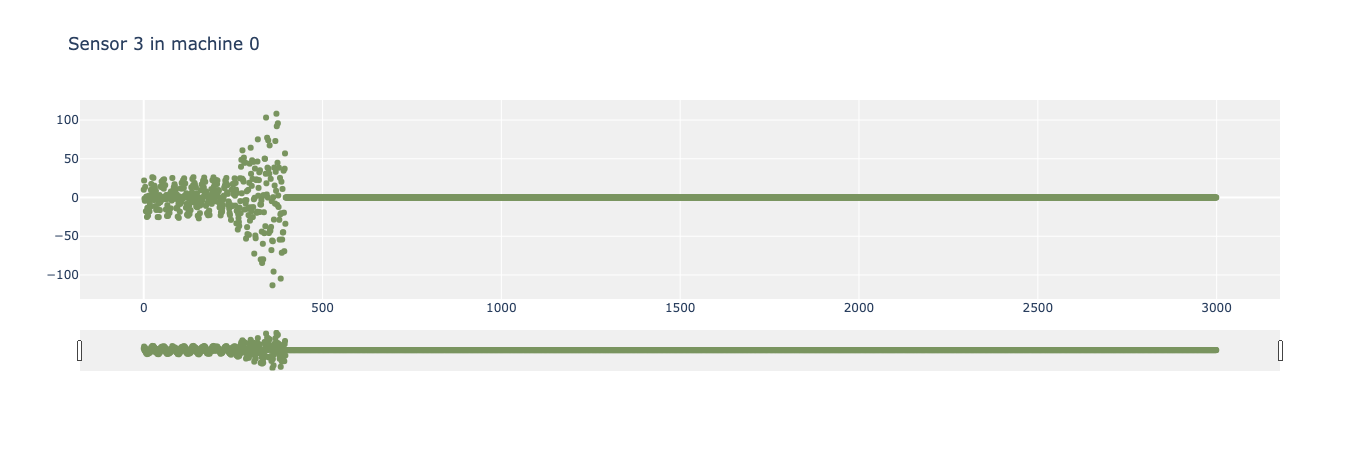

In [9]:
visualize_machine_and_one_sensor_with_plotly(0, 3)

If we focus on smaller time frame (like 200 points), we can see that the normal mode of sensor 3 can be well modelled with two frequencies.

If plotly doesn't work, you can use this function to visualize the faulty mode in greater detail. We use a simple rule to find the failure time: the first moment when the rolling average (with window size equal to 3) is lower than 0.05.

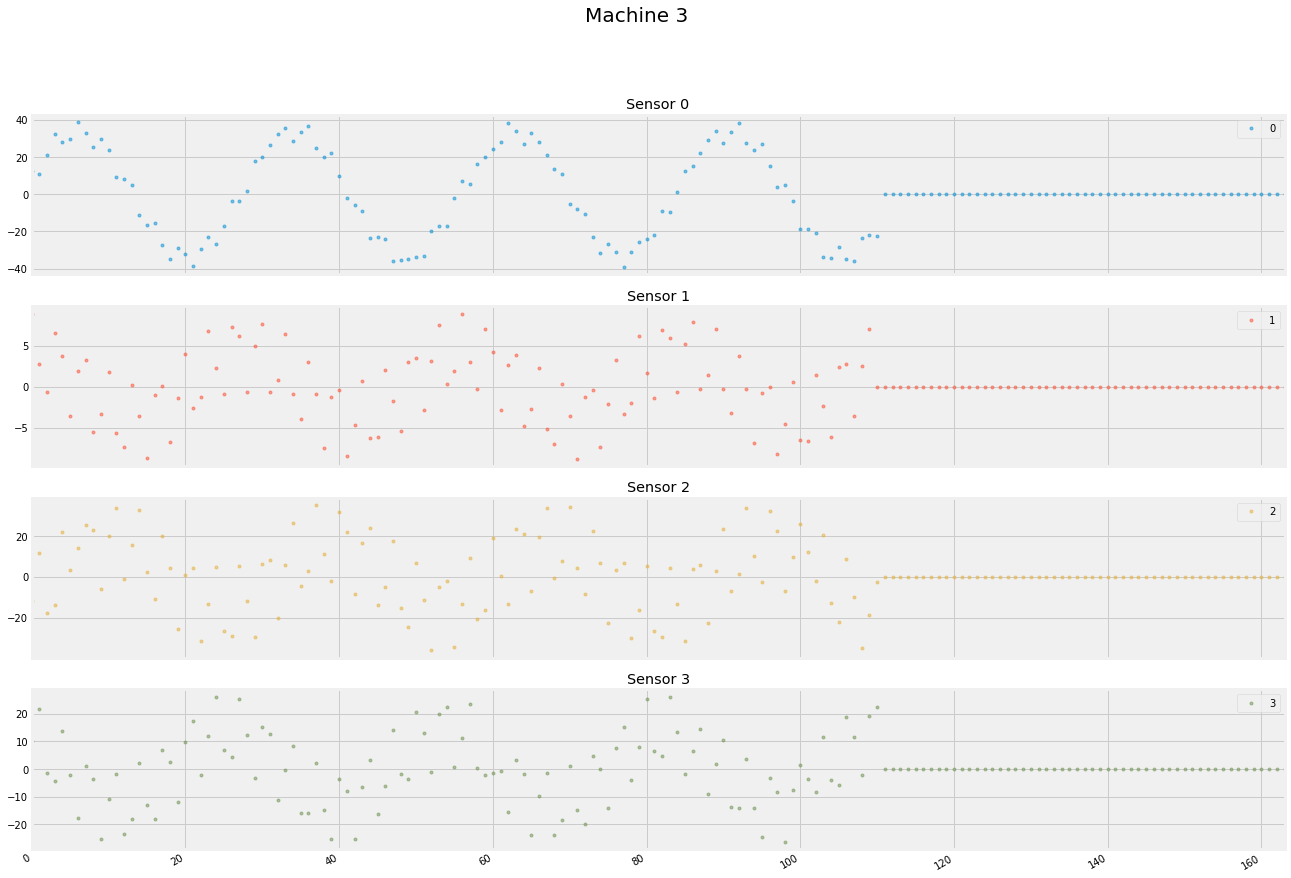

In [10]:
def find_failure_time(data):
    sensor_0_abs = data['0'].abs()
    rolling_average = sensor_0_abs.rolling(window=3).mean()
    for i in range(len(rolling_average)):
        if rolling_average[i] < 0.05:
            return i

def find_fault_time_retrospectively(data):
    return max(0, find_failure_time(data) - 200)

def visualize_faulty_mode(machine_id):
    data = pd.read_csv(f"denoised_data/machine_{machine_id}.csv",index_col=0)
    data = data.reset_index()
    
    failure_time = find_failure_time(data)
    
    cols_plot = ['0', '1', '2', '3']
    axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 15), subplots=True)
    for ax in axes:
        label = ax.get_legend_handles_labels()[1][0]
        ax.set_title(f"Sensor {label}")
        ax.legend(loc='upper right')
        ax.set_xlim(max(failure_time-500, 0), failure_time+50)
    plt.suptitle(f"Machine {machine_id}", fontsize=20)

visualize_faulty_mode(3)

### Key observations and hypotheses from EDA:

* The behaviour of each sensor is the similiar for every machine
* The faulty mode changes the behaviour of all 4 sensors
* Machines 3, 8 and 10 seem to skip the fualty mode.
* When entering the faulty mode, the behaviour of all 4 sensors seem to change at similiar time
* The normal mode of sensor 0 can be well modelled with a $sin$ function and while entering the faulty mode this pattern dissapers and then the range of values grows before entering the failed mode. The behaviour of sensor 0 is the most predicatble.
* The normal mode of sensor 1 resembles an overlapping waves of two frequencies. The faulty mode can be characterized by more chaotic pattern and growing range of values.
* The behaviour of sensor 2 is harder to describe.  
* The behaviour of sensor 3 can be characterized by two overlapping wave functions and the faulty mode starts when the relative offset of these waves changes and the waves merge into one. 

## Strategy

Our goal is to **develop an automated method to pinpoint the times of fault and failure in this machine.** Furthermore, we want this method to be generalizable, so it should not involve too many hard coded parameters. To accomplish this, we will implement the following approach:

1. Find the timeframe when the machine was operating in normal mode. In our case, it can be done by finding the failure moment (this is easy) and substracting the logest observed length of the faulty phase.
2. Use the data about normal mode to fit a model that predicts next $k$ values. It can any model, for example we will use this function $a \sin(2 \pi (x-c)/b)$ to model the normal mode of sensor $0$. Later, we will experiment with deep learning models.
3. Observe the mean squared error of the predicted points, if it suddenly increases it might suggest that the machine entered the faulty mode.


## Simple model

As we mentioned earlier, the sensor 1 in normal mode can be well-modeled by a simple function of a form $a \sin(2 \pi (x-c)/b)$ where $a$, $b$ and $c$ are constants to be found. One way to find the period $B$ is to use fourier transform -- the frequency with the greatest norm of the Fourier Transform is likely to be the period. 

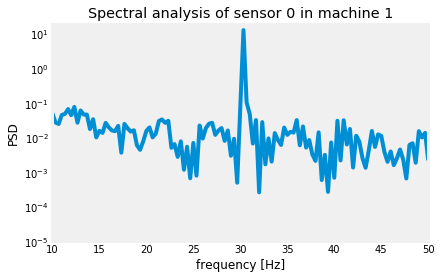

In [11]:
import scipy.signal as signal

data = pd.read_csv(f"denoised_data/machine_1.csv",index_col=0)

fs = 100
# we only use the normal mode
x = data['0'].values[:300]
f, psd = signal.periodogram(x, fs, scaling='spectrum')

plt.semilogy(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
ax = plt.gca()
ax.set_xlim(10, 50)
ax.set_ylim(0.00001, 20)
ax.set_title("Spectral analysis of sensor 0 in machine 1")
plt.grid()
plt.show()


Or we can just fit the model to the data.

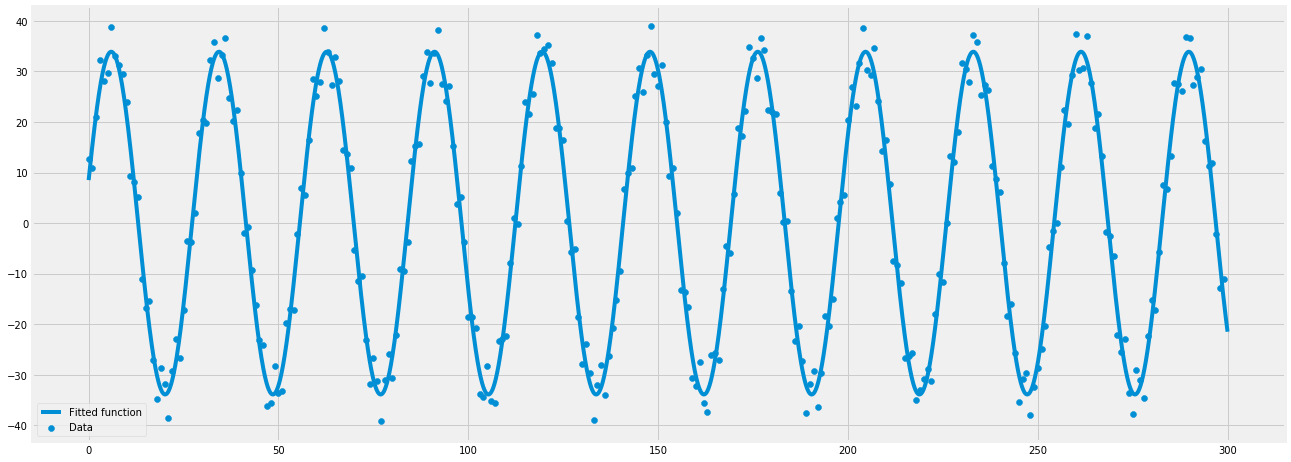

(array([-33.90936088,  28.38521976,  13.04659057]), 14.064048906717847)


In [13]:
from scipy import optimize

def one_frequency_model(x, amplitude, period, shift):
    return amplitude * np.sin(2*np.pi * (x-shift)/period)

def fit_one_frequency_model(data, end_of_normal_mode=300, plot=False):
    y = data['0'].values[:end_of_normal_mode]
    x = np.linspace(0, end_of_normal_mode, 3000, endpoint=True)
    
    end_of_normal_mode = find_fault_time_retrospectively(data)

    try:
        params, _ = optimize.curve_fit(one_frequency_model, range(len(y)), y, p0=[38.968, 30, 2], maxfev = 1600)
    except RuntimeError:
        # params from machine 1
        params = [-33.83484209,  28.38679749,  13.01959637]
    
    if plot:
        plt.figure(figsize=(20, 8))
        plt.scatter(range(len(y)), y, label='Data')
        plt.plot(x, [one_frequency_model(i, *params) for i in x],
                 label='Fitted function')

        plt.legend(loc='best')
        plt.show()

    mse = sum([(one_frequency_model(x, *params) - y[x])**2 for x in range(len(y))])/len(y)
    
    return params, mse

def get_one_frequency_fitted_model(data):
    params, _ = fit_one_frequency_model(data)
    
    def fitted_model(x):
        return one_frequency_model(x, *params)
    
    return fitted_model

data = pd.read_csv(f"denoised_data/machine_2.csv",index_col=0)

print(fit_one_frequency_model(data, plot=True))

Now we can repeat procedure with slightly more complicated example, namely sensor 3. Let's verify the hypothesis that the normal mode of sensor 3 is composed of two frequencies.

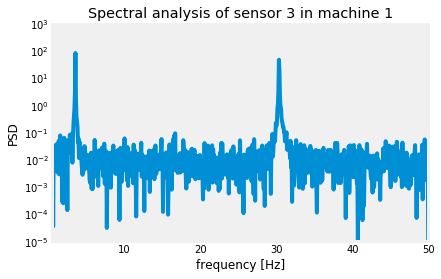

In [14]:
data = pd.read_csv(f"denoised_data/machine_1.csv",index_col=0)

fs = 100
# we only use the normal mode
x = data['3'].values[:1500]
f, psd = signal.periodogram(x, fs, scaling='spectrum')

plt.semilogy(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
ax = plt.gca()
ax.set_xlim(0.5, 50)
ax.set_ylim(0.00001, 1000)
ax.set_title("Spectral analysis of sensor 3 in machine 1")
plt.grid()
plt.show()

Since the data is noisy, the plot is a little bit messy. To fix it, we can use Welch method, which is more suitable for spectral analysis of noisy data:

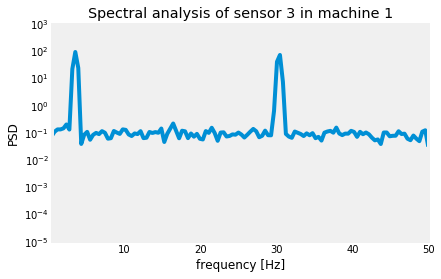

In [15]:
f, psd = signal.welch(x, fs, scaling='spectrum')

plt.semilogy(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
ax = plt.gca()
ax.set_xlim(0.5, 50)
ax.set_ylim(0.00001, 1000)
ax.set_title("Spectral analysis of sensor 3 in machine 1")
plt.grid()
plt.show()


We can clearly see two spikes, suggesting that the sensor 3 can be well modelled with the following function:

$$f(x) = a_1 \sin(2 \pi (x-s_1) / p_1) + a_2  \sin(2 \pi (x-s_2) /p_2 )$$


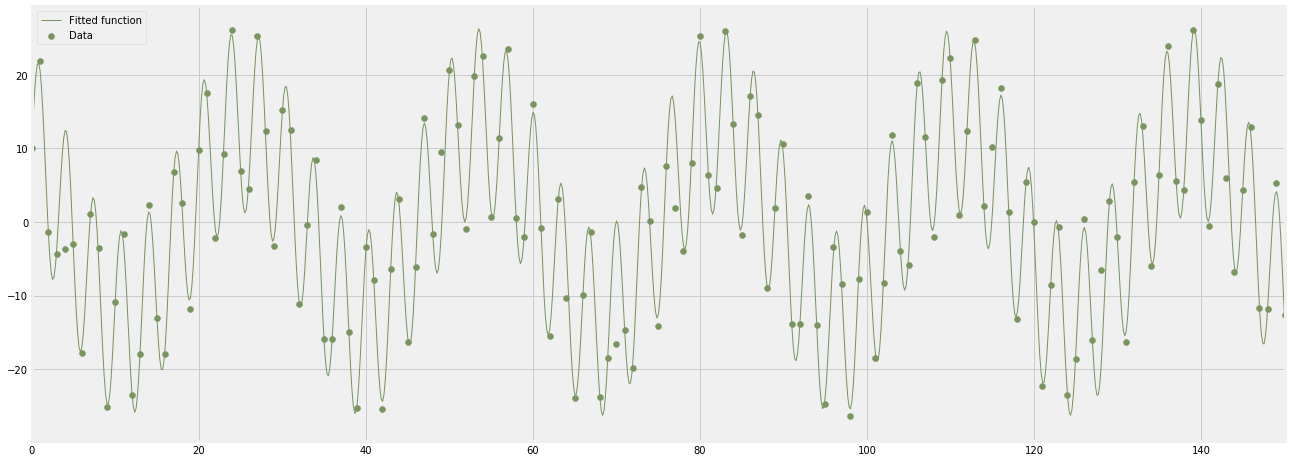

(array([-13.75323629,   4.08772809,  28.3974909 , -12.53832946,
        -1.63733494,   3.29409415]), 9.020129349925162)


In [16]:
def two_frequency_model(x, a_1, s_1, p_1, a_2, s_2, p_2):
    return a_1*np.sin(2*np.pi*(x-s_1)/p_1)  + a_2*np.sin(2 * np.pi*(x-s_2) / p_2 )

def fit_two_frequency_model(data, end_of_normal_mode=500, plot=False, sensor=3):
    y = data[str(sensor)].values[:end_of_normal_mode]
    x = np.linspace(0, end_of_normal_mode, 3000, endpoint=True)
    
    first_guess = {
        'a_1': -13.9,
        's_1': 0,
        'p_1': 28.5,
        'a_2': 12.5,
        's_2': 0,
        'p_2': 3.28
    }
    
    try:
        params, _ = optimize.curve_fit(two_frequency_model, range(len(y)), y, p0=list(first_guess.values()), maxfev = 1600)
    except RuntimeError:
        # params fitten from machine 1
        params = [-13.75323629,   4.08772809,  28.3974909 , -12.53832946, -1.63733494,   3.29409415]
    
    if plot:
        plt.figure(figsize=(20, 8))
        plt.scatter(range(len(y)), y, label='Data', color=COLOR_DICT[sensor])
        plt.plot(x, [two_frequency_model(i, *params) for i in x],
                 label='Fitted function', color=COLOR_DICT[sensor], linewidth=1)

        plt.legend(loc='best')
        ax = plt.gca()
        ax.set_xlim(0, 150)
        plt.show()

    mse = sum([(two_frequency_model(x, *params) - y[x])**2 for x in range(len(y))])/len(y)
    
    return params, mse
    
def get_two_frequency_fitted_model(data):
    params, _ = fit_two_frequency_model(data)
    
    def fitted_model(x):
        return two_frequency_model(x, *params)
    
    return fitted_model

data = pd.read_csv(f"denoised_data/machine_1.csv",index_col=0)
print(fit_two_frequency_model(data, plot=True))


## Predicting failure

Having modeled the normal mode, we can procede to predicting failure. We will monitor root mean squared error of the predictions, and we will predict the time of fault if it increases above a certain treshold. Let's define this threshold to be given by maximal value of rmse encountered in the first $k$ points plus three standard deviations of this sample.

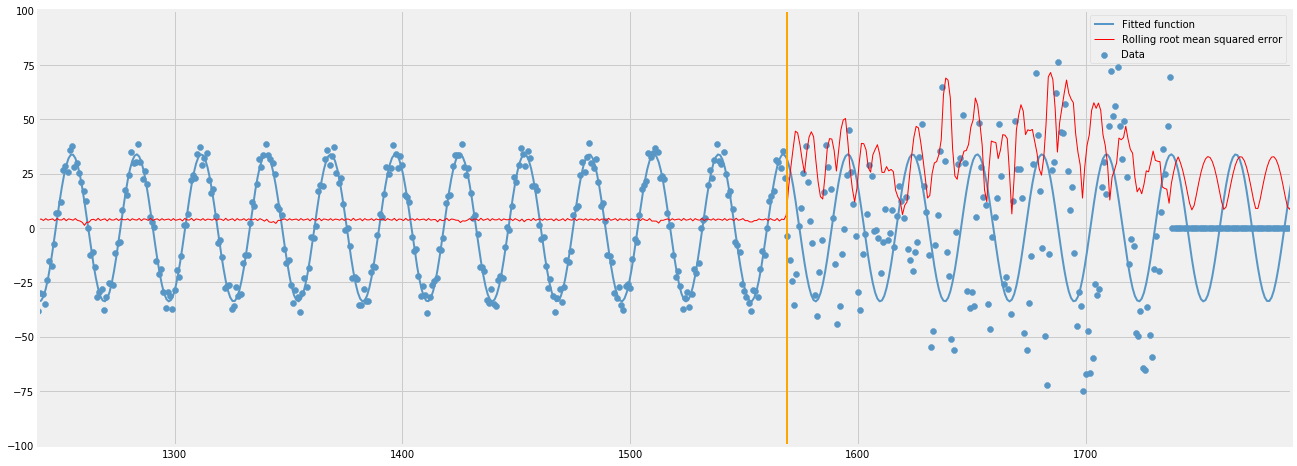

1569

In [17]:
def get_fault_time_by_sensor_0(machine_id, plot=True):
    data = pd.read_csv(f"denoised_data/machine_{machine_id}.csv",index_col=0)
    data = data.reset_index().drop(['index'], axis=1)
    
    # the machine failed before we had enough data to model the normal mode
    # check if machine didn't fail before 300
    if find_failure_time(data) < 300:
        return -1
    
    function = get_one_frequency_fitted_model(data)

    data["predicted_0"] = [function(i) for i in range(len(data))]
    data['se_0'] = (data['0'] - data['predicted_0'])**2
    data["rolling_mse"] = data["se_0"].rolling(4).mean()
    data["rolling_rmse"] = np.sqrt(data["rolling_mse"])

    rmse_threshold = max(data["rolling_rmse"].fillna(0).values[:100]) + 3 * np.std(data["rolling_rmse"].fillna(0).values[:100])

    fault_time = data[data['rolling_rmse'].gt(rmse_threshold)].index[0]
    
    if plot:
        failure_time = find_failure_time(data)
        y = data['0'].values
        x = np.linspace(0, len(y), 3000, endpoint=True)

        plt.figure(figsize=(20, 8))
        plt.scatter(range(len(y)), y, label='Data', color=COLOR_DICT[0], )
        plt.plot(x, [function(i) for i in x],
                     label='Fitted function', color=COLOR_DICT[0], linewidth=2)
        plt.plot(x, data["rolling_rmse"].values, label='Rolling root mean squared error', color='red', linewidth=1)

        ax = plt.gca()
        ax.set_xlim(max(failure_time-500, 0), failure_time+50)
        ax.set_ylim(-100, 100)
        ax.axvline(x=fault_time, color='orange', linewidth=2)
        plt.legend(loc='best')
        plt.show()
        
    return fault_time
    
get_fault_time_by_sensor_0(1)

The prediction is very accurate! There is no way, we would detect the fault so early by only analyzing the range of values. 

Let's try to do the same with sensor 3.

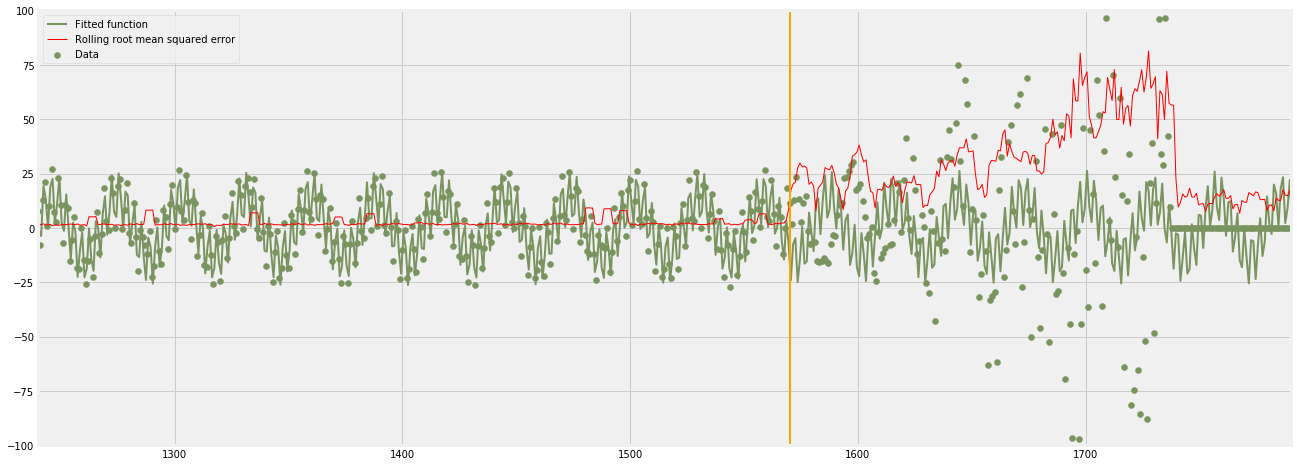

1570

In [18]:
def get_fault_time_by_sensor_3(machine_id, plot=True):
    data = pd.read_csv(f"denoised_data/machine_{machine_id}.csv",index_col=0)
    data = data.reset_index().drop(['index'], axis=1)
    
    # check if machine didn't fail before 300
    if find_failure_time(data) < 500:
        return -1
    

    function = get_two_frequency_fitted_model(data)

    data["predicted_3"] = [function(i) for i in range(len(data))]
    data['se_3'] = (data['3'] - data['predicted_3'])**2
    data["rolling_mse"] = data["se_3"].rolling(4).mean()
    data["rolling_rmse"] = np.sqrt(data["rolling_mse"].fillna(0))
    
    
    rmse_threshold = 15
    
    if max(data["rolling_rmse"].values) < rmse_threshold:
        return 0
    
    fault_time = data[data['rolling_rmse'].gt(rmse_threshold)].index[0]

    if plot:
        failure_time = find_failure_time(data)
        y = data['3'].values
        x = np.linspace(0, len(y), 3000, endpoint=True)

        plt.figure(figsize=(20, 8))
        plt.scatter(range(len(y)), y, label='Data', color=COLOR_DICT[3], )
        plt.plot(x, [function(i) for i in x],
                     label='Fitted function', color=COLOR_DICT[3], linewidth=2)
        plt.plot(x, data["rolling_rmse"].values, label='Rolling root mean squared error', color='red', linewidth=1)

        ax = plt.gca()
        ax.set_xlim(max(failure_time-500, 0), failure_time+50)
        ax.set_ylim(-100, 100)
        ax.axvline(x=fault_time, color='orange', linewidth=2)
        plt.legend(loc='best')
        plt.show()
        
    return fault_time
    
get_fault_time_by_sensor_3(1, plot=True)

The two methods gave almost the same answer, they differ only by 1 unit of time (1569 vs 1570). Let's see if the method is able to detect the fault moment in other examples.

In [19]:
for i in range(N):
    print(f"Machine {i}")
    fault_time_by_sensor_0 = get_fault_time_by_sensor_0(i, plot=False) # change plot=False to plot=True to see the plots
    fault_time_by_sensor_3 = get_fault_time_by_sensor_3(i, plot=False)
    if fault_time_by_sensor_0 and fault_time_by_sensor_3:
        print("Difference of predictions", abs(fault_time_by_sensor_0 - fault_time_by_sensor_3))
    print("Fault time by sensor 0: ", fault_time_by_sensor_0)
    print("Fault time by sensor 3: ", fault_time_by_sensor_3)
    print("\n")

Machine 0
Difference of predictions 207
Fault time by sensor 0:  206
Fault time by sensor 3:  -1


Machine 1
Difference of predictions 1
Fault time by sensor 0:  1569
Fault time by sensor 3:  1570


Machine 2
Difference of predictions 31
Fault time by sensor 0:  1702
Fault time by sensor 3:  1733


Machine 3
Difference of predictions 0
Fault time by sensor 0:  -1
Fault time by sensor 3:  -1


Machine 4
Difference of predictions 0
Fault time by sensor 0:  -1
Fault time by sensor 3:  -1


Machine 5
Difference of predictions 200
Fault time by sensor 0:  199
Fault time by sensor 3:  -1


Machine 6
Difference of predictions 4
Fault time by sensor 0:  406
Fault time by sensor 3:  410


Machine 7
Difference of predictions 3
Fault time by sensor 0:  1257
Fault time by sensor 3:  1260


Machine 8
Difference of predictions 11
Fault time by sensor 0:  895
Fault time by sensor 3:  906


Machine 9
Difference of predictions 6
Fault time by sensor 0:  611
Fault time by sensor 3:  617


Machine 10
Dif

-1 means that the machine failed very early, and there is no enough data to model the normal mode.

## Limitations & Improvements

The largest limitation of our solution is that we require certain minimal amount of data to model the normal mode of a given machine. If we assume that normal modes of a given sensor are the same across all the machines (and it seems to be the case in our example), we could use data from one machine to model the normal mode of other machine.

While the implementation of my approach has certain limitation, the general idea seems to be aplicable in real life. **We can presume that a machine is in normal mode if the sensor data is predictable.** If suddenly, the data starts to deviate from our predictions, it might be a signal that the machine entered the faulty mode. In this exercise, we've used a very simple model but in principle, the method is as good as the model used to predict the sensor data.

Please note that I didn't divide the provided data into training, test and validation data because each *prediction* of the fault time was done by the model using the data only from a given machine. 

Other improvements:
* Using more generalizable model predicting the sensor data. Deep learning is very aplicable here.
* Using Dask to make the implementation suitable for handling large files.
* Making code more general and reusable, add documentation (currenly it's notebook style code).

### Alternative approach

I did consider labelling the data manually and approaching the problem as a supervised ML task but I chose not to do it for two reasons. Firstly, **labels were not a part of the given data so I didn't want to introduce my bias to the data.** Secondly, the other approach (anomally detection) seems to be more general.